# NN training

В этой тетрадке мы решим нашу первую серьезную задачу - [Imagenette](https://github.com/fastai/imagenette#imagenette-1) 
(сабсет ImageNet) и поиграем с подбором гиперпараметров.

**Всегда поможет:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)

# Как оценивается этот ноутбук?

Для этого ноутбука не будет автотестов. Я буду проверять отчет в конце ноутбука, при необходимости проверять сам код. Пожалуйста, постарайтесь аккуратно его заполнить


### GPU

Чтобы ускорить вычисления можно поменять тип рантайма в колабе. `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`

Можно работать с ноутбуком и локально, если есть видюха

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data

Для обучения мы будем использовать облегченную версию датасета Imagenette с минимальной стороной равной 160 пикселям.  
Следующие две ячейки должны скачать и распаковать данные, после чего в текущей директории появится 
директория `imagenette2-160` со следующей структурой:

- ./imagenette2-160/
    - train/
        - {CLASS_ID}/{IMAGE_ID}.jpeg
    - val/
        - {CLASS_ID}/{IMAGE_ID}.jpeg

In [2]:
# download tar archive

# ! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

In [3]:
# extract files from archive

# ! tar -zxf imagenette2-160.tgz
# ! tar -zxf imagenette2-160.tar

In [4]:
# !ls -l imagenette2-160

In [5]:
import pandas as pd

pd.read_csv('imagenette2-160/noisy_imagenette.csv')


,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False
...,...,...,...,...,...,...,...
13389,val/n03425413/n03425413_17521.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,True
13390,val/n03425413/n03425413_20711.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,True
13391,val/n03425413/n03425413_19050.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,True
13392,val/n03425413/n03425413_13831.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,True


## Dataset
Напишите класс `ImagenetteDataset`, который мы будем использовать для обучения сетки.  

*Hints:* 

1. Нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`. 
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset)).
1. Для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
1. Обратите внимание на то, что возвращает функция `cv2.imread`. 
Какой порядок каналов в полученном массиве?
1. В батче не может быть тензоров разного размера. В датасете есть картинки с разными шириной/высотой. Их нужно привести к одному размеру, проще всего, если это будет квадратная картинка. Можно просто заресайзить, см [Resize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)

In [6]:
import matplotlib.pyplot as plt

In [7]:
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os.path as path
from sklearn.preprocessing import LabelEncoder
import pandas as pd

from torchvision.transforms import ToTensor, Compose, Resize, ToPILImage

class ImagenetteDataset(Dataset):
    def __init__(self, csv='./imagenette2-160/noisy_imagenette.csv', train=True, transform=None, 
                 labels_column='noisy_labels_0',
                 augmentation=None):

        """
        labels_column отвечает из какой колонки будем получать лейблы классов для обучения/валидации, будем использовать `noisy_labels_0`

        Так как значения лейблов -- это строки, для того, чтобы превратить их в числа, можно воспользоваться LabelEncoder
        """
        data = pd.read_csv(csv)
        enc = LabelEncoder()
        labels = data[labels_column]
        data[labels_column] = enc.fit_transform(labels)
        self.label_col = labels_column
        self.transform = transform
        self.augmentation = augmentation
        if train:
            self.data = data[~data['is_valid']].copy()
        else:
            self.data = data[data['is_valid']].copy()


    def __len__(self):
        # return dataset length
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # load image
        # transform image
        # return dict with image and class label
        item = self.data.iloc[index]
        img = cv2.imread('./imagenette2-160/' + item['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).type(torch.float32).unsqueeze(0) / 255
            
        if self.augmentation:
            if np.random.random() < 0.5:
                img = self.augmentation(img)
        label = item[self.label_col]
        return {"image": img, "label": label}

In [8]:
image_size = 128

transform = Compose([
                    ToTensor(),
                    Resize((image_size, image_size)),
])

train_imagenet = ImagenetteDataset(train=True, transform=transform)
val_imagenet = ImagenetteDataset(train=False, transform=transform)


dataloader = DataLoader(train_imagenet, batch_size=128)
next(iter(dataloader))

{'image': tensor([[[[0.6765, 0.6760, 0.6757,  ..., 0.9839, 0.8710, 0.7642],
           [0.6917, 0.6878, 0.6837,  ..., 0.9314, 0.8139, 0.6805],
           [0.6892, 0.6853, 0.6763,  ..., 0.8293, 0.6339, 0.7809],
           ...,
           [0.4255, 0.4245, 0.4235,  ..., 0.6358, 0.6117, 0.5681],
           [0.5284, 0.5250, 0.5200,  ..., 0.6317, 0.6068, 0.5616],
           [0.3900, 0.3838, 0.3773,  ..., 0.6173, 0.5901, 0.5444]],
 
          [[0.6765, 0.6760, 0.6757,  ..., 0.9839, 0.8710, 0.7642],
           [0.6917, 0.6878, 0.6837,  ..., 0.9314, 0.8139, 0.6805],
           [0.6892, 0.6853, 0.6763,  ..., 0.8293, 0.6339, 0.7809],
           ...,
           [0.4255, 0.4245, 0.4235,  ..., 0.4906, 0.4680, 0.4282],
           [0.5284, 0.5250, 0.5200,  ..., 0.4866, 0.4656, 0.4217],
           [0.3900, 0.3838, 0.3773,  ..., 0.4721, 0.4489, 0.4057]],
 
          [[0.6765, 0.6760, 0.6757,  ..., 0.9839, 0.8710, 0.7642],
           [0.6917, 0.6878, 0.6837,  ..., 0.9314, 0.8139, 0.6805],
           [0.6

## Trainer
Перенесите свой класс `Trainer` и создайте его инстанс.

*Hints:*

1. Можете взять любую архитектуру сети из предыдущей домашки/семинара или из `torchvision.models`: 
[link](https://pytorch.org/vision/stable/models.html#classification)

In [35]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


class VeryModel(nn.Module):
    def __init__(self, image_size, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.inner = nn.Sequential(nn.Flatten(),
                                   nn.Linear(3 * image_size * image_size, 512),
#                                    nn.ReLU(),
                                   nn.Tanh(),
                                   nn.Linear(512, 128),
#                                    nn.ReLU(),
                                   nn.Tanh(),
                                   nn.Linear(128, 10),
#                                    nn.ReLU()
                                   nn.Tanh())

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

            
class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 batch_size: int = 128,
                 lr_scheduler = None, 
                 lr_scheduler_type = None,
                 tboard_log_dir: str = './hw2_tb_logs/',
                 exp_name = None):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        
        self.tboard_log_dir = tboard_log_dir
        
        if exp_name == 'batch_size':
            self.tboard_log_dir = tboard_log_dir + 'batch_exp_' + str(batch_size) + '/'
        elif exp_name == 'augmentation':
            self.tboard_log_dir = tboard_log_dir + 'augm_exp_' + str(train_dataset.augmentation) + '/'
        elif exp_name == 'lr_scheduler':
            self.tboard_log_dir = tboard_log_dir + 'lr_sched_exp_' + str(self.lr_scheduler) + '/'
        else:
            self.tboard_log_dir = tboard_log_dir
        
        self.log_writer_train = SummaryWriter(log_dir=self.tboard_log_dir+'train/')
        self.log_writer_val = SummaryWriter(log_dir=self.tboard_log_dir+'val/')

        # сохраняем состояние оптимизатора и модели
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int = 1):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

#                 model.post_train_batch()
                if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
                    self.lr_scheduler.step()
                
                for k, v in details.items():
                    self.log_writer_train.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1
                
                self.log_writer_train.add_scalar('train_loss', loss.item(), global_step=self.global_step)
                self.log_writer_train.add_scalar('train_acc', details['acc'], global_step=self.global_step)
                
            

            with torch.no_grad():
                model.eval()
                
                val_losses = []
                val_accuracies = []
                
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    val_losses.append(loss.item())
                    val_accuracies.append(details['acc'])
                    
                    
                val_loss = np.mean(val_losses)
                val_accuracy = np.mean(val_accuracies)
#                 print('Loss, acc:', val_loss, val_accuracy)
                all_val = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, 
                                     batch_size=len(self.val_dataset))
                for batch in all_val:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    full_loss, full_details = model.compute_all(batch)
#                     print(full_loss.item(), full_details['acc'])
        
                self.log_writer_val.add_scalar('val_loss', full_loss, global_step=self.global_step)
                self.log_writer_val.add_scalar('val_acc', full_details['acc'], global_step=self.global_step)
            
#                 model.post_val_stage(val_loss)
                if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
                    self.lr_scheduler.step(val_loss)
                
                
                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss
                    
            print('Epoch:', epoch+1)
            print('Avg_loss:', full_loss.item())
            print('Avg_acc:', full_details['acc'])

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        train_loader_iter = iter(train_loader)

        model.train()
        
        for lr in tqdm(lrs, desc='finding LR', total=num_lrs):

            try:
                batch = next(train_loader_iter)
            except StopIteration:
                train_loader_iter = iter(train_loader)
                batch = next(train_loader_iter)
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss.item())
            logs['loss'].append(loss.item())

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

## LR Range Test

Проведите LR Range Test и выберите LR в оптимальных границах.

*Requirement:* график в осях LR - loss должен быть в аутпуте ячейки.

* Постройте графики `LR - loss` для разных batch_size: 64, 256, 512
* Используйте `SGD` в качестве оптимизатора
* Графики должны быть хорошо читаемымми. Без оочень больших выбросов

**Подсказка-спойлер** в [гисте](https://gist.github.com/mrsndmn/90344fd7ce7be2a008376d7056f2a660)


In [10]:
from torch.optim import SGD

image_size = 128

model = VeryModel(image_size)
optimizer = SGD(model.parameters(), lr=3e-4)

transform = Compose([
                    ToTensor(),
                    Resize((image_size, image_size)),
])

train_imagenet = ImagenetteDataset(train=True, transform=transform)
val_imagenet = ImagenetteDataset(train=False, transform=transform)

trainer = Trainer(model, optimizer, train_imagenet, val_imagenet, batch_size=256)

In [11]:
import matplotlib.pyplot as plt

def plot_find_lr(trainer, batch_size=64, num_lrs=400, 
                 min_lr=1e-7, max_lr=2e-2,
                 smooth_beta=0.8): # todo possibly another params
    """
    Тут нужно провести range test и построить график для заданного batch_size
    """

    trainer.batch_size = batch_size

    find_learning_rate_logs = trainer.find_lr(min_lr, max_lr, num_lrs, smooth_beta)
    plt.plot(find_learning_rate_logs['lr'], find_learning_rate_logs['loss'])
    plt.plot(find_learning_rate_logs['lr'], find_learning_rate_logs['avg_loss'])


    plt.xscale('log')
    plt.gcf().set_size_inches((10, 5))
    plt.xlabel("log lr")
    plt.ylabel("loss")
    plt.title(f"Log scale loss(lr) bs={trainer.batch_size}")

    return find_learning_rate_logs

finding LR: 100%|█████████████████████████████| 400/400 [01:43<00:00,  3.86it/s]


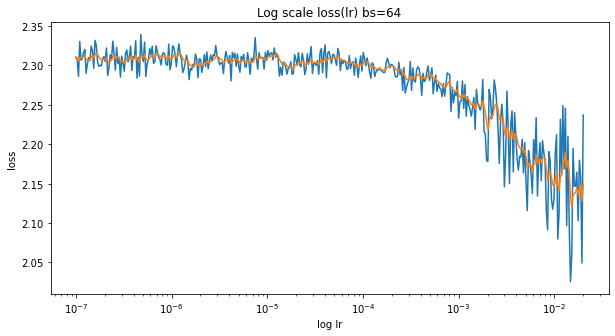

In [12]:
plot_find_lr(trainer, batch_size=64);

finding LR: 100%|█████████████████████████████| 400/400 [04:00<00:00,  1.66it/s]


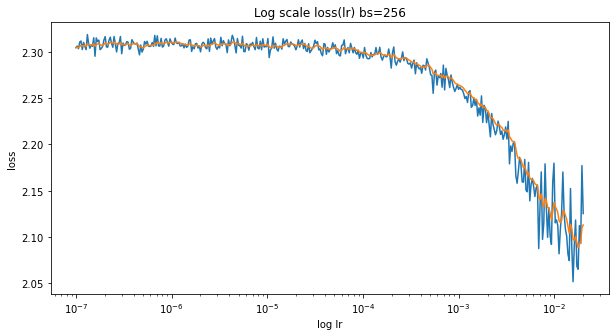

In [13]:
plot_find_lr(trainer, batch_size=256);

finding LR: 100%|█████████████████████████████| 400/400 [06:57<00:00,  1.04s/it]


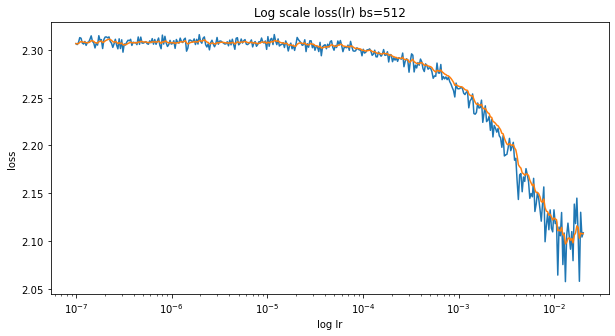

In [14]:
plot_find_lr(trainer, batch_size=512);

## Обучение

Обучите baseline сеть с выбранным LR и batch_size. Остальные гиперпараметры выберите по своему усмотрению.

Попробуйте улучшить логирование в нашем трейнере:

1. Логи разных экспериментов должен быть в отдельных папках, чтобы их можно было сравнить в тензорборде
(см. аргумент `log_dir` в [docs](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter)).
1. Должна логироваться `Accuracy` после валидационной эпохи
1. На этапе валидации метрика должна считаться по всем валидационным объектам, а не отдельно по каждому батчу. 
В тензорборде после валидации должна появиться одна точка для одной метрики на валидации (кроме accuracy можно еще логировать лосс на валидации).

In [15]:
from torch.optim import SGD

best_bs, best_lr = 256, 3e-3
tboard_logdir = './hw2_tb_logs/'
image_size = 128

model = VeryModel(image_size)
optimizer = SGD(model.parameters(), lr=best_lr)

transform = Compose([
                    ToTensor(),
                    Resize((image_size, image_size)),
])

train_imagenet = ImagenetteDataset(train=True, transform=transform)
val_imagenet = ImagenetteDataset(train=False, transform=transform)

trainer = Trainer(model, optimizer, train_imagenet, val_imagenet, 
                  batch_size=best_bs, tboard_log_dir=tboard_logdir)

In [16]:
trainer.train(5)

100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch: 1
Avg_loss: 2.2088375091552734
Avg_acc: 0.23184714


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch: 2
Avg_loss: 2.150300979614258
Avg_acc: 0.28713375


100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.67it/s]


Epoch: 3
Avg_loss: 2.1193249225616455
Avg_acc: 0.30726114


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.77it/s]


Epoch: 4
Avg_loss: 2.1047654151916504
Avg_acc: 0.29324841


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.80it/s]


Epoch: 5
Avg_loss: 2.0801477432250977
Avg_acc: 0.3197452


In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir ./hw2_tb_logs

## Больше экспериментов

Попробуйте различные гиперпараметры при обучении. Что дает набольший эффект?  

1. Batch size
1. Аугментации из torchvision.transforms (например [RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation), [RandomHorizontalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip), что еще вам понравится ). Более подробно, что делают разные трансформы можно посмотреть в [ноутбуке](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
1. LR scheduler. На семинаре рассмотрели разные типы шедулеров, код и ссылки на шедулеры 

*Requirement:* сделайте скриншот тензорборда (несколько, если считаете нужным) с кривыми обучения
(лоссы/метрики на трейне/валидации) проведенных экспериментов и вставьте их в отчет ниже.
Из скриншота должно быть понятно в чем заключался эксперимент и как проходило обучение.

*Hint 1:* не меняйте несколько гиперпараметров в одном эксперименте - так непонятно какой из них сыграл.  


#### Batch size:

In [19]:
best_lr = 3e-3
tboard_logdir = './hw2_tb_logs_batch/'
image_size = 128

batch_sizes = [32, 128, 512]

for bs in batch_sizes:

    model = VeryModel(image_size)
    optimizer = SGD(model.parameters(), lr=best_lr)

    transform = Compose([
                        ToTensor(),
                        Resize((image_size, image_size)),
    ])

    train_imagenet = ImagenetteDataset(train=True, transform=transform)
    val_imagenet = ImagenetteDataset(train=False, transform=transform)

    trainer = Trainer(model, optimizer, train_imagenet, val_imagenet, 
                      batch_size=bs, tboard_log_dir=tboard_logdir, exp_name='batch_size')
    print('\n\nBatch size =', bs)
    trainer.train(5)



Batch size = 32


100%|█████████████████████████████████████████| 123/123 [00:08<00:00, 14.46it/s]


Epoch: 1
Avg_loss: 2.066422939300537
Avg_acc: 0.30751592


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.77it/s]


Epoch: 2
Avg_loss: 2.0096611976623535
Avg_acc: 0.33707008


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.93it/s]


Epoch: 3
Avg_loss: 1.976226806640625
Avg_acc: 0.35949045


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 17.14it/s]


Epoch: 4
Avg_loss: 1.9612146615982056
Avg_acc: 0.35261145


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.71it/s]


Epoch: 5
Avg_loss: 1.9398622512817383
Avg_acc: 0.36356688


Batch size = 128


100%|███████████████████████████████████████████| 31/31 [00:05<00:00,  5.21it/s]


Epoch: 1
Avg_loss: 2.15451979637146
Avg_acc: 0.26369426


100%|███████████████████████████████████████████| 31/31 [00:05<00:00,  5.19it/s]


Epoch: 2
Avg_loss: 2.1011743545532227
Avg_acc: 0.30955413


100%|███████████████████████████████████████████| 31/31 [00:06<00:00,  5.09it/s]


Epoch: 3
Avg_loss: 2.0707170963287354
Avg_acc: 0.30267516


100%|███████████████████████████████████████████| 31/31 [00:05<00:00,  5.18it/s]


Epoch: 4
Avg_loss: 2.0489602088928223
Avg_acc: 0.3266242


100%|███████████████████████████████████████████| 31/31 [00:05<00:00,  5.20it/s]


Epoch: 5
Avg_loss: 2.0341451168060303
Avg_acc: 0.32509553


Batch size = 512


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch: 1
Avg_loss: 2.2428224086761475
Avg_acc: 0.23872611


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch: 2
Avg_loss: 2.1994106769561768
Avg_acc: 0.23872611


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch: 3
Avg_loss: 2.171261787414551
Avg_acc: 0.27133757


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch: 4
Avg_loss: 2.147160053253174
Avg_acc: 0.30165604


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.43it/s]


Epoch: 5
Avg_loss: 2.1281309127807617
Avg_acc: 0.29757962


In [72]:
%tensorboard --logdir ./hw2_tb_logs_batch

#### Augmentation:

In [21]:
from torchvision.transforms import RandomHorizontalFlip, RandomRotation

best_lr = 3e-3
tboard_logdir = './hw2_tb_logs_augmentation/'
image_size = 128

bs = 32

augs = [RandomHorizontalFlip(), RandomRotation(30)]

for aug in augs:

    model = VeryModel(image_size)
    optimizer = SGD(model.parameters(), lr=best_lr)

    transform = Compose([
                        ToTensor(),
                        Resize((image_size, image_size)),
    ])

    train_imagenet = ImagenetteDataset(train=True, transform=transform, augmentation=aug)
    val_imagenet = ImagenetteDataset(train=False, transform=transform)

    trainer = Trainer(model, optimizer, train_imagenet, val_imagenet, 
                      batch_size=bs, tboard_log_dir=tboard_logdir, exp_name='augmentation')
    print('\n\nAugmentation = ' + str(aug))
    trainer.train(5)



Augmentation = RandomHorizontalFlip(p=0.5)


100%|█████████████████████████████████████████| 123/123 [00:08<00:00, 15.23it/s]


Epoch: 1
Avg_loss: 2.0778720378875732
Avg_acc: 0.2820382


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 15.97it/s]


Epoch: 2
Avg_loss: 2.005652904510498
Avg_acc: 0.32942677


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 15.78it/s]


Epoch: 3
Avg_loss: 1.9709969758987427
Avg_acc: 0.362293


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 16.74it/s]


Epoch: 4
Avg_loss: 1.9616581201553345
Avg_acc: 0.34980893


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 17.10it/s]


Epoch: 5
Avg_loss: 1.9498685598373413
Avg_acc: 0.35745224


Augmentation = RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 17.54it/s]


Epoch: 1
Avg_loss: 2.0645551681518555
Avg_acc: 0.31159237


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 16.74it/s]


Epoch: 2
Avg_loss: 2.0167574882507324
Avg_acc: 0.3322293


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 16.51it/s]


Epoch: 3
Avg_loss: 1.9830718040466309
Avg_acc: 0.34496814


100%|█████████████████████████████████████████| 123/123 [00:08<00:00, 14.23it/s]


Epoch: 4
Avg_loss: 1.9697462320327759
Avg_acc: 0.34191084


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 15.85it/s]


Epoch: 5
Avg_loss: 1.9496835470199585
Avg_acc: 0.36280254


In [71]:
%tensorboard --logdir ./hw2_tb_logs_augmentation

#### LR scheduler:

In [38]:
from torch.optim.lr_scheduler import StepLR, CyclicLR

best_lr = 3e-3
tboard_logdir = './hw2_tb_logs_sched/'
image_size = 128

bs = 32
aug = RandomRotation(30)


# per_batch:

model_step = VeryModel(image_size)
optimizer = SGD(model_step.parameters(), lr=best_lr)

transform = Compose([
                    ToTensor(),
                    Resize((image_size, image_size)),
])

train_imagenet = ImagenetteDataset(train=True, transform=transform, augmentation=aug)
val_imagenet = ImagenetteDataset(train=False, transform=transform)

lr_sched = StepLR(optimizer, step_size=200, gamma=0.7, verbose=False)
sched_type = 'per_batch'

trainer = Trainer(model_step, optimizer, train_imagenet, val_imagenet, 
                  batch_size=bs, lr_scheduler=lr_sched, lr_scheduler_type=sched_type,
                  tboard_log_dir=tboard_logdir, exp_name='lr_scheduler')
print('\n\nLR scheduler =  StepLR(optimizer, step_size=200, gamma=0.7)')
trainer.train(5)

# per_epoch:

model_cyclic = VeryModel(image_size)
optimizer = SGD(model_cyclic.parameters(), lr=best_lr)

transform = Compose([
                    ToTensor(),
                    Resize((image_size, image_size)),
])

train_imagenet = ImagenetteDataset(train=True, transform=transform, augmentation=aug)
val_imagenet = ImagenetteDataset(train=False, transform=transform)

lr_sched = CyclicLR(optimizer, base_lr=best_lr, max_lr=7e-3, verbose=False)
sched_type = 'per_epoch'

trainer = Trainer(model_cyclic, optimizer, train_imagenet, val_imagenet, 
                  batch_size=bs, lr_scheduler=lr_sched, lr_scheduler_type=sched_type,
                  tboard_log_dir=tboard_logdir, exp_name='lr_scheduler')
print('\n\nLR scheduler = CyclicLR(optimizer, base_lr=best_lr, max_lr=7e-3)')
trainer.train(5)



LR scheduler =  StepLR(optimizer, step_size=200, gamma=0.7)


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.78it/s]


Epoch: 1
Avg_loss: 2.073779821395874
Avg_acc: 0.3143949


100%|█████████████████████████████████████████| 123/123 [00:09<00:00, 12.93it/s]


Epoch: 2
Avg_loss: 2.0406079292297363
Avg_acc: 0.3253503


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 18.03it/s]


Epoch: 3
Avg_loss: 2.022770643234253
Avg_acc: 0.34420383


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.92it/s]


Epoch: 4
Avg_loss: 2.014054298400879
Avg_acc: 0.34089172


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.59it/s]


Epoch: 5
Avg_loss: 2.0082881450653076
Avg_acc: 0.33961785


LR scheduler = CyclicLR(optimizer, base_lr=best_lr, max_lr=7e-3)


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 17.12it/s]
/Users/19700643/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1
Avg_loss: 2.0188028812408447
Avg_acc: 0.30165604


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.81it/s]


Epoch: 2
Avg_loss: 1.9163029193878174
Avg_acc: 0.3546497


100%|█████████████████████████████████████████| 123/123 [00:07<00:00, 17.54it/s]


Epoch: 3
Avg_loss: 1.946635365486145
Avg_acc: 0.33299363


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.65it/s]


Epoch: 4
Avg_loss: 1.8705371618270874
Avg_acc: 0.37910828


100%|█████████████████████████████████████████| 123/123 [00:06<00:00, 17.77it/s]


Epoch: 5
Avg_loss: 1.9102158546447754
Avg_acc: 0.33375797


In [39]:
%tensorboard --logdir ./hw2_tb_logs_sched

# Отчет


В целом, не так важно, какое качество вы получите на этой задаче --- сильно зависит от модели, которую вы обучаете, но скорее всего, вы переиспользуете какую-нибудь модель из домашки/сема. 

Важнее понять, как разные параметры влияют на скорость обучения и относительное качество модели.



## [0.2 балла] Find lr

Выведете графики `Log scale loss(lr)` для batch_size in (64, 256, 512)

Как ведет себя оптимальное значение `learning_rate`'а с увеличением batch_size?

| batch_size       |  Оптимальное значение learning_rate   |
|------------------|---------------------------------------|
| 64               |  1e-4<lr<2e-3                                 |
| 256              |  5e-4<lr<5e-3                                  |
| 512              |  7e-4<lr<7e-3                                  |


С увеличением batch_size заметно уменьшение амлитуды скачков (что логично, так как двигаемся в сторону антиградиента по большинству объектов). Для batch_size=64 хороший интервал достаточно сложно определить на глаз. 

С увеличением batch_size заметно увеличение опимального значения скорости.

Чем больше батч, тем дольше учится модель.

## [0.1 балл] Обучение

* Baseline модель обучалась **5** эпох.
* Accuracy на валидации **0.32**


## Больше экспериментов


*Requirement:* сделайте скриншот тензорборда (несколько, если считаете нужным) с кривыми обучения
(лоссы/метрики на трейне/валидации) проведенных экспериментов и вставьте их в отчет ниже.
Из скриншота должно быть понятно в чем заключался эксперимент и как проходило обучение.

*Hint 1:* не меняйте несколько гиперпараметров в одном эксперименте - так непонятно какой из них сыграл.  



#### [0.2 балла] Batch size

* Как изменилась скорость обучения?
* Как изменилось качество модели?

* Совпадают ли результаты эксперимента с теоретическими ожиданиями? Если нет, как вы можете это объяснить?

Модель быстрее учится при большем размере батча (хотя и по большим батчам дольше считать, но самих батчей становится меньше, поэтому в общем быстрее).

Качество модели наибольшее при наименьшем (из перебранных) batch_size = 32. Дальше экспериментировать буду на этом значении. Accuracy = 0.364.

В целом результаты совпали с ожиданиями. Однако казалось, что при большем батче точность движения в сторону оптимума больше, поэтому и качество должно бы быть лучше. Но потом понял, что при меньших батчах мы выигрываем более частыми пересчетами весов и этим движемся эффективнее к оптимуму.

Скрины тензорборда:

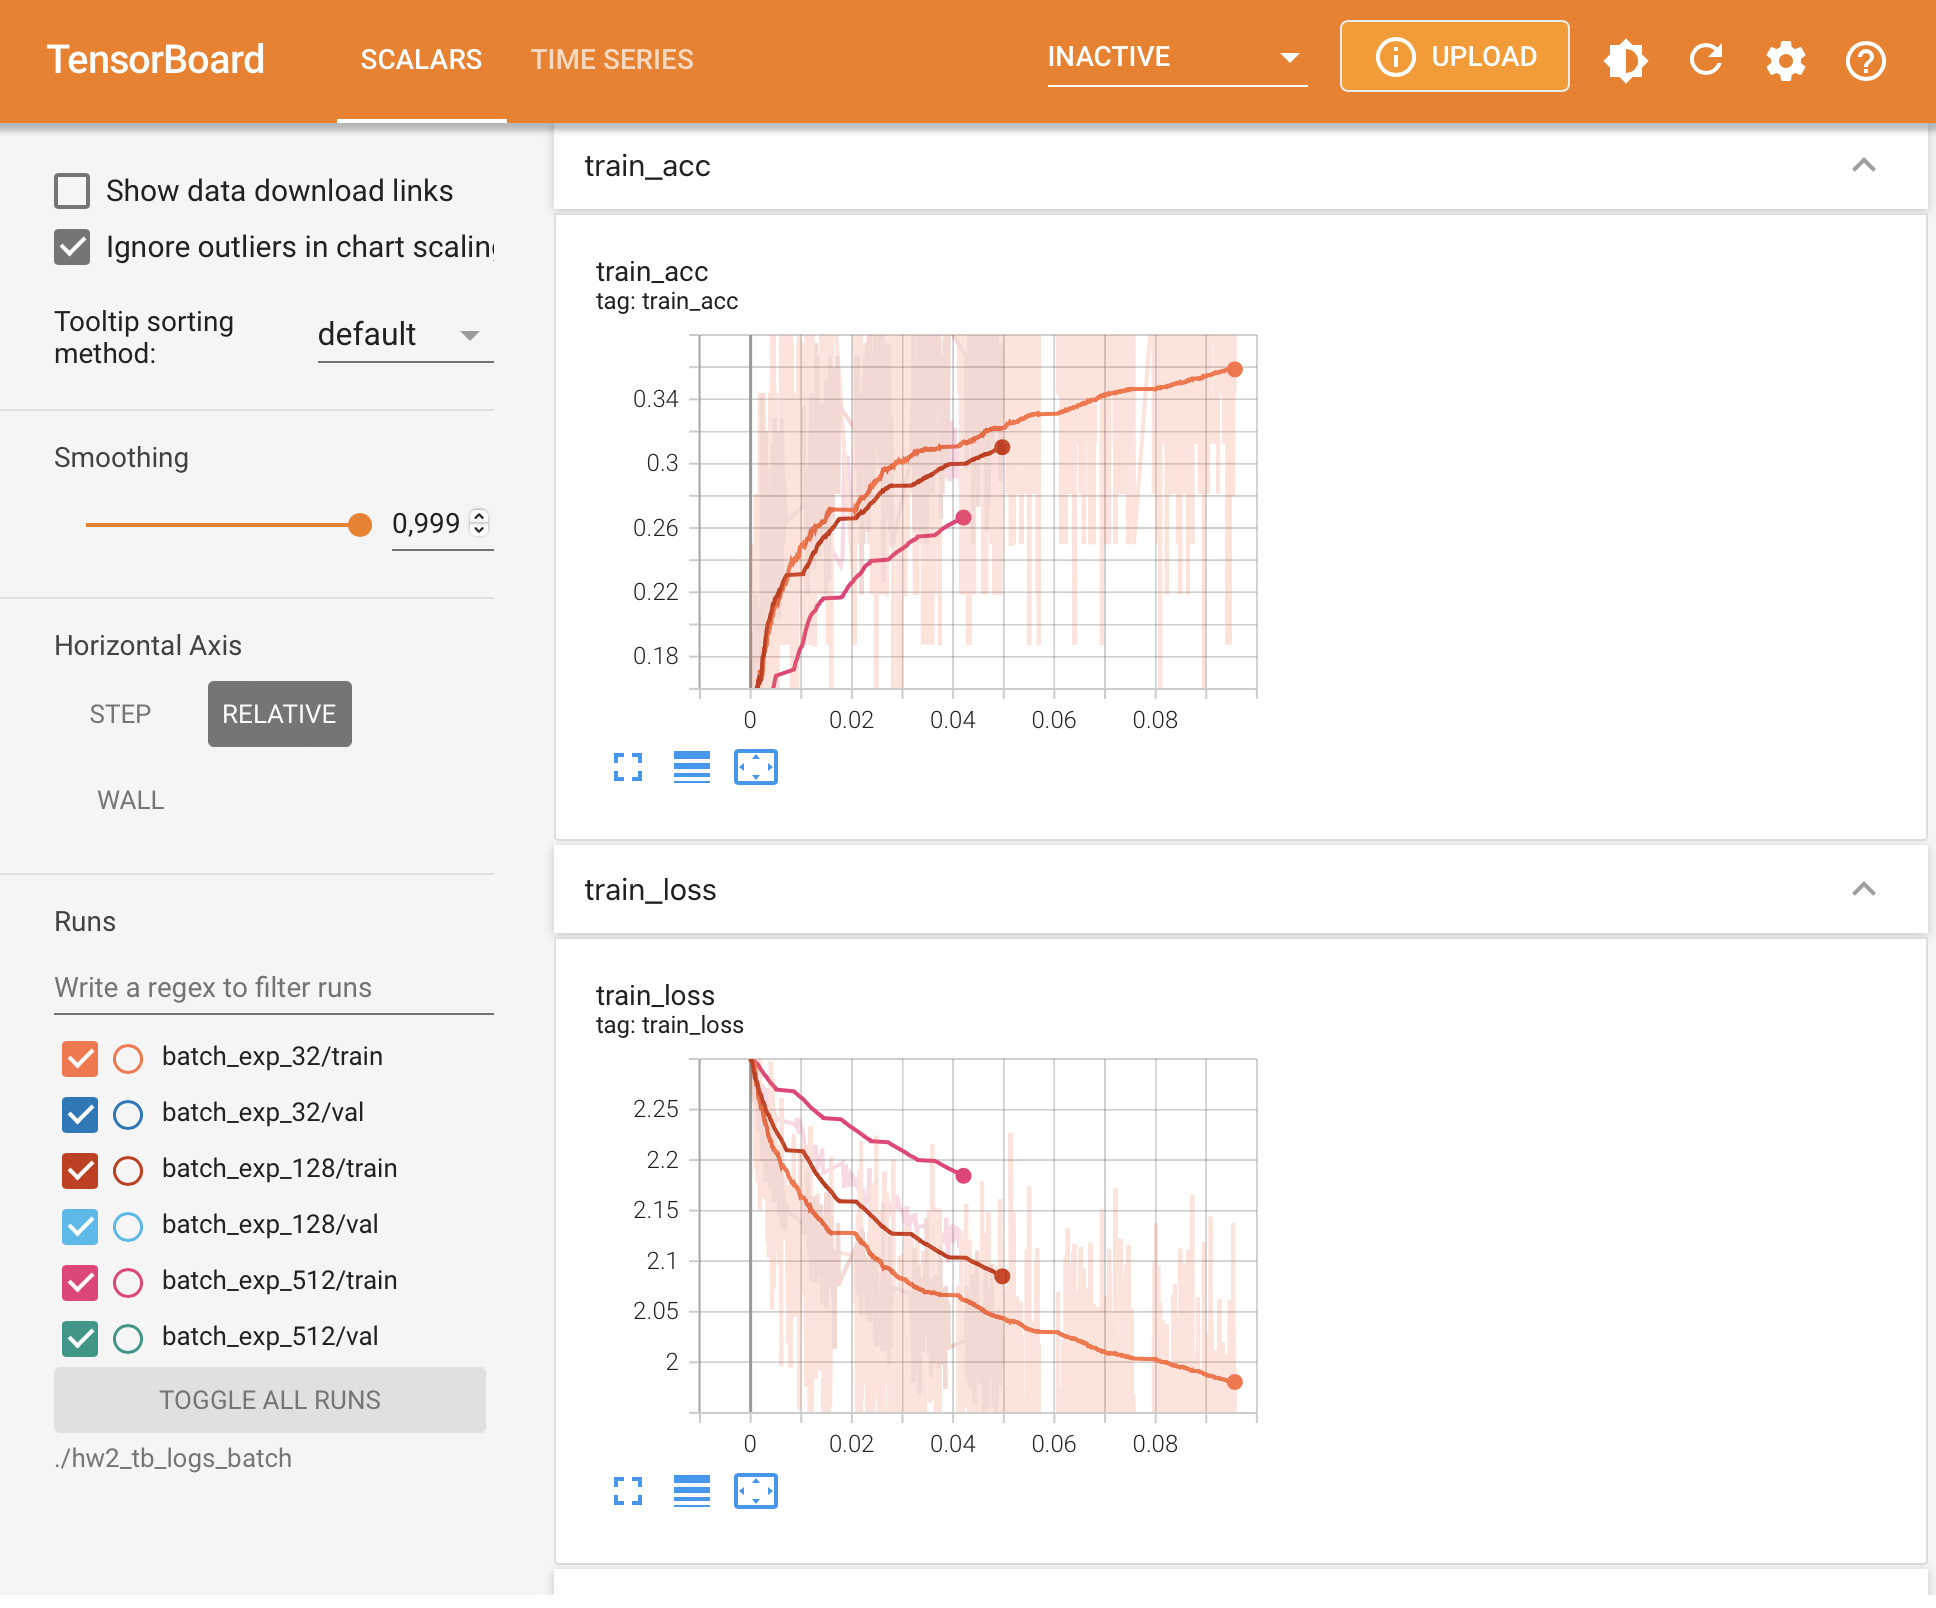

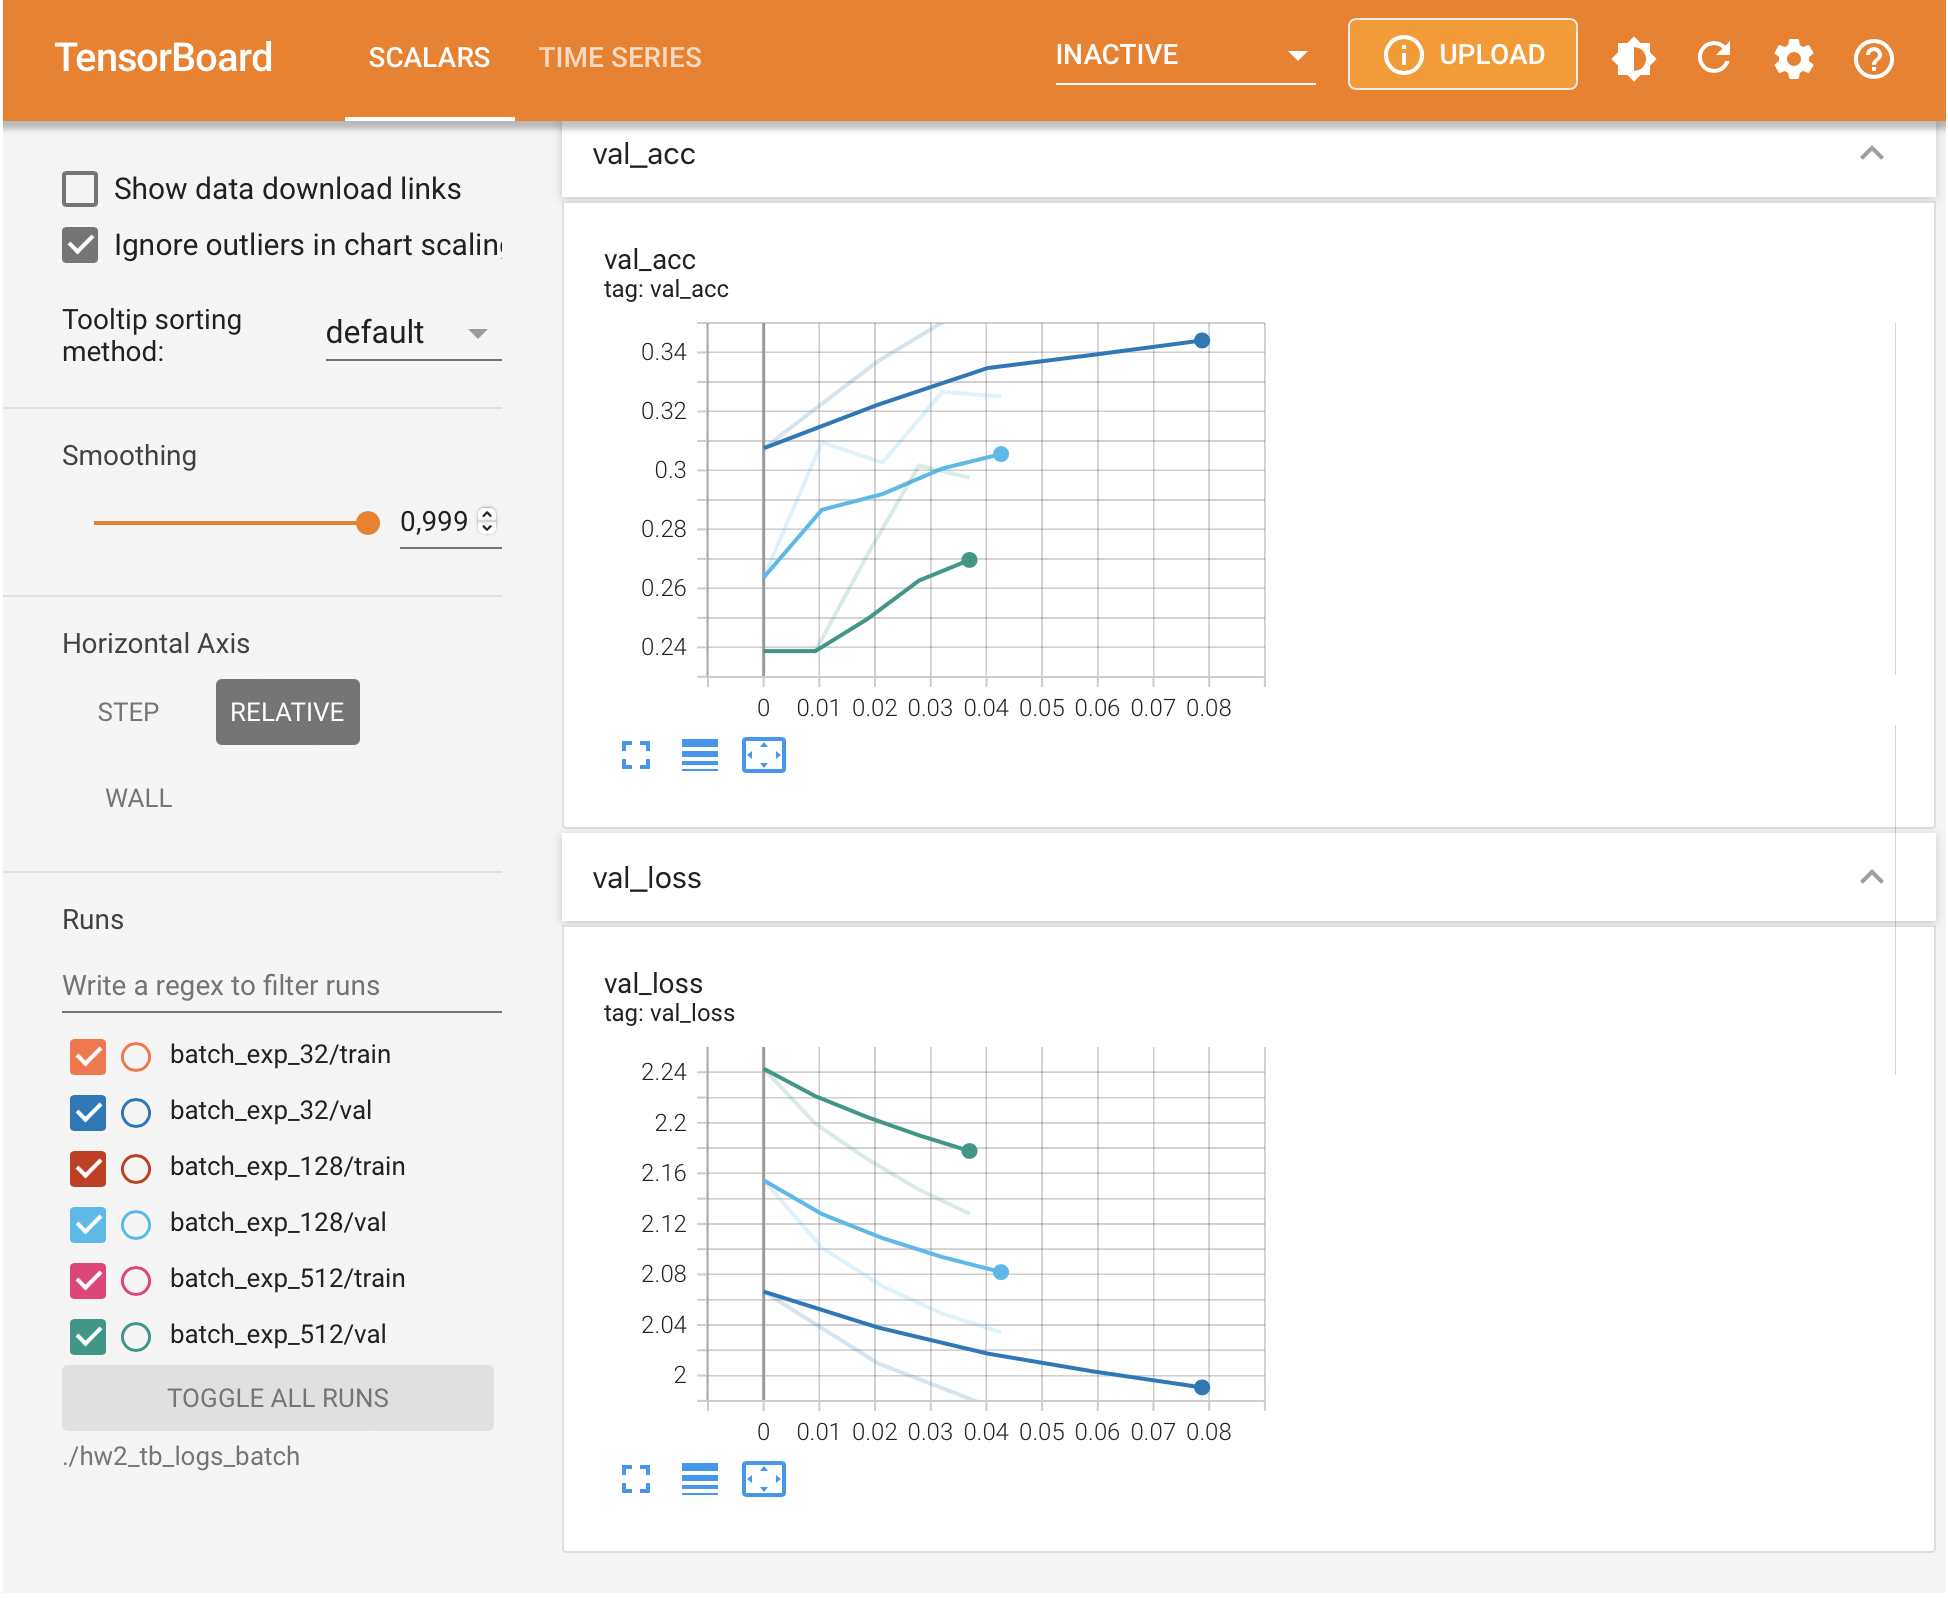


#### [0.2 балла] Аугментации

* Как изменилась скорость обучения?
* Как изменилось качество модели?

* Совпадают ли результаты эксперимента с теоретическими ожиданиями? Если нет, как вы можете это объяснить?

Скорость обучения примерно одинаковая, качество стало лучше, чем без аугментаций, однако с аугментациями примерно одинаково (лучшей оказалась RandomRotation(30), Accuracy = 0.363, дальше буду экспериментировать с этой моделью).

Результаты совпали с ожиданиями (с аугментациями выборка становится разнообразнее, поэтому качество увеличивается).

Скрины с тензорборда:

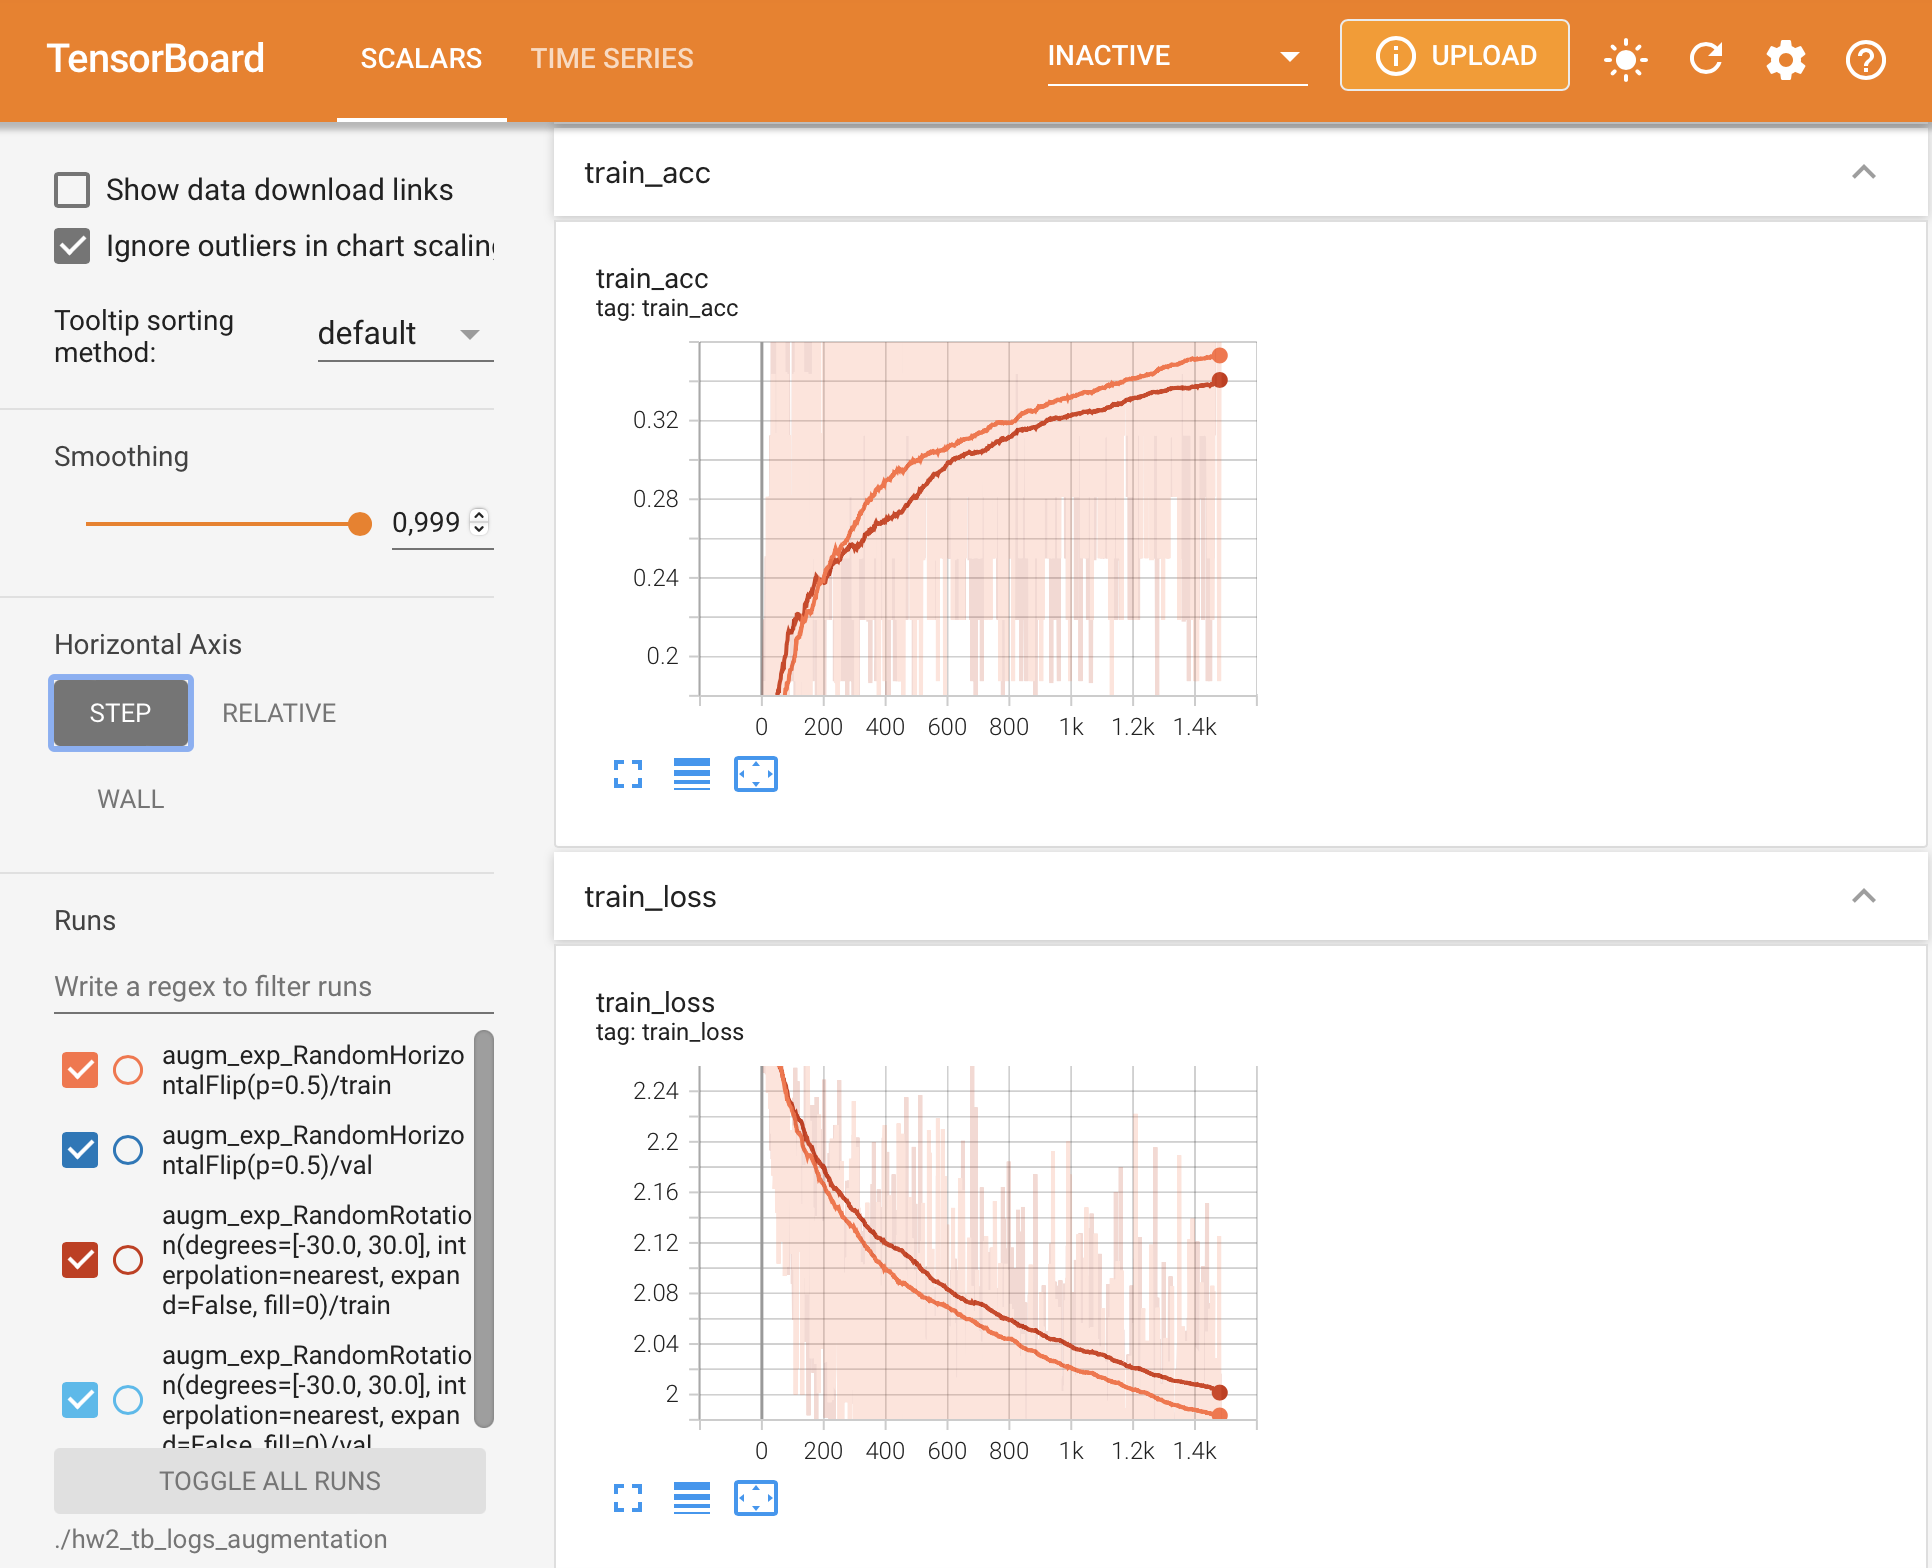

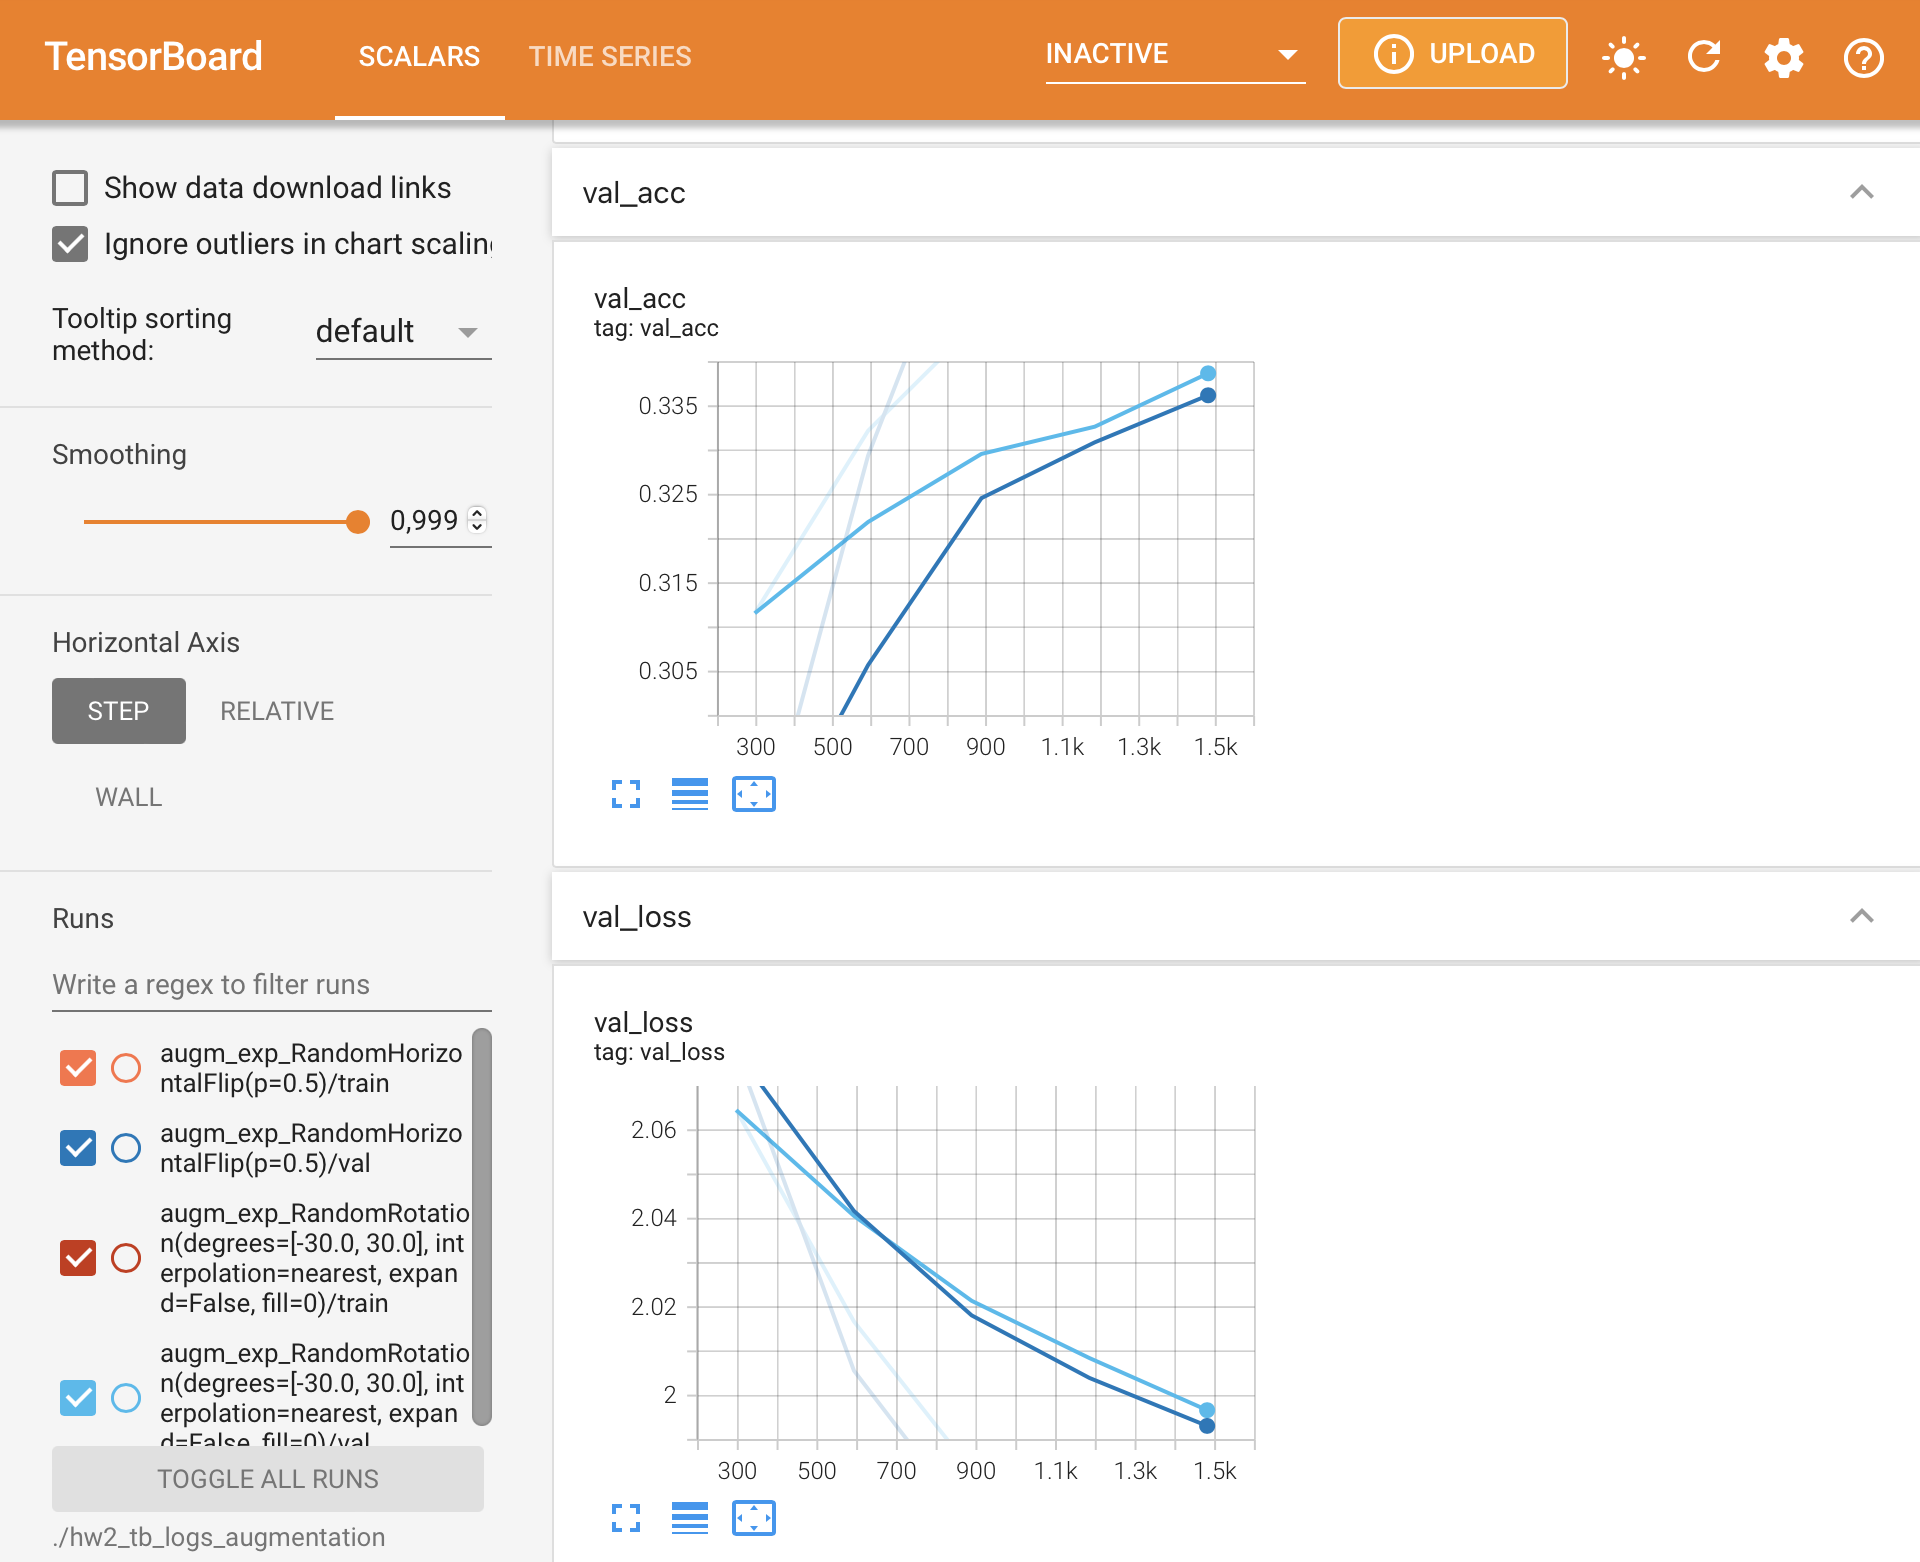


#### [0.2 балла] LR scheduler.

* Как изменилась скорость обучения?
* Как изменилось качество модели?

* Совпадают ли результаты эксперимента с теоретическими ожиданиями? Если нет, как вы можете это объяснить?

Скорость не изменилась, качество увеличилось на Cyclic (возможно увеличилось бы и на stepLR, если хорошо подобрать параметры). Результаты совпадают с ожиданиями. Лучшая модель на Cyclic, Accuracy = 0.379 (на 4 эпохах).

Скрины с тензорборда:

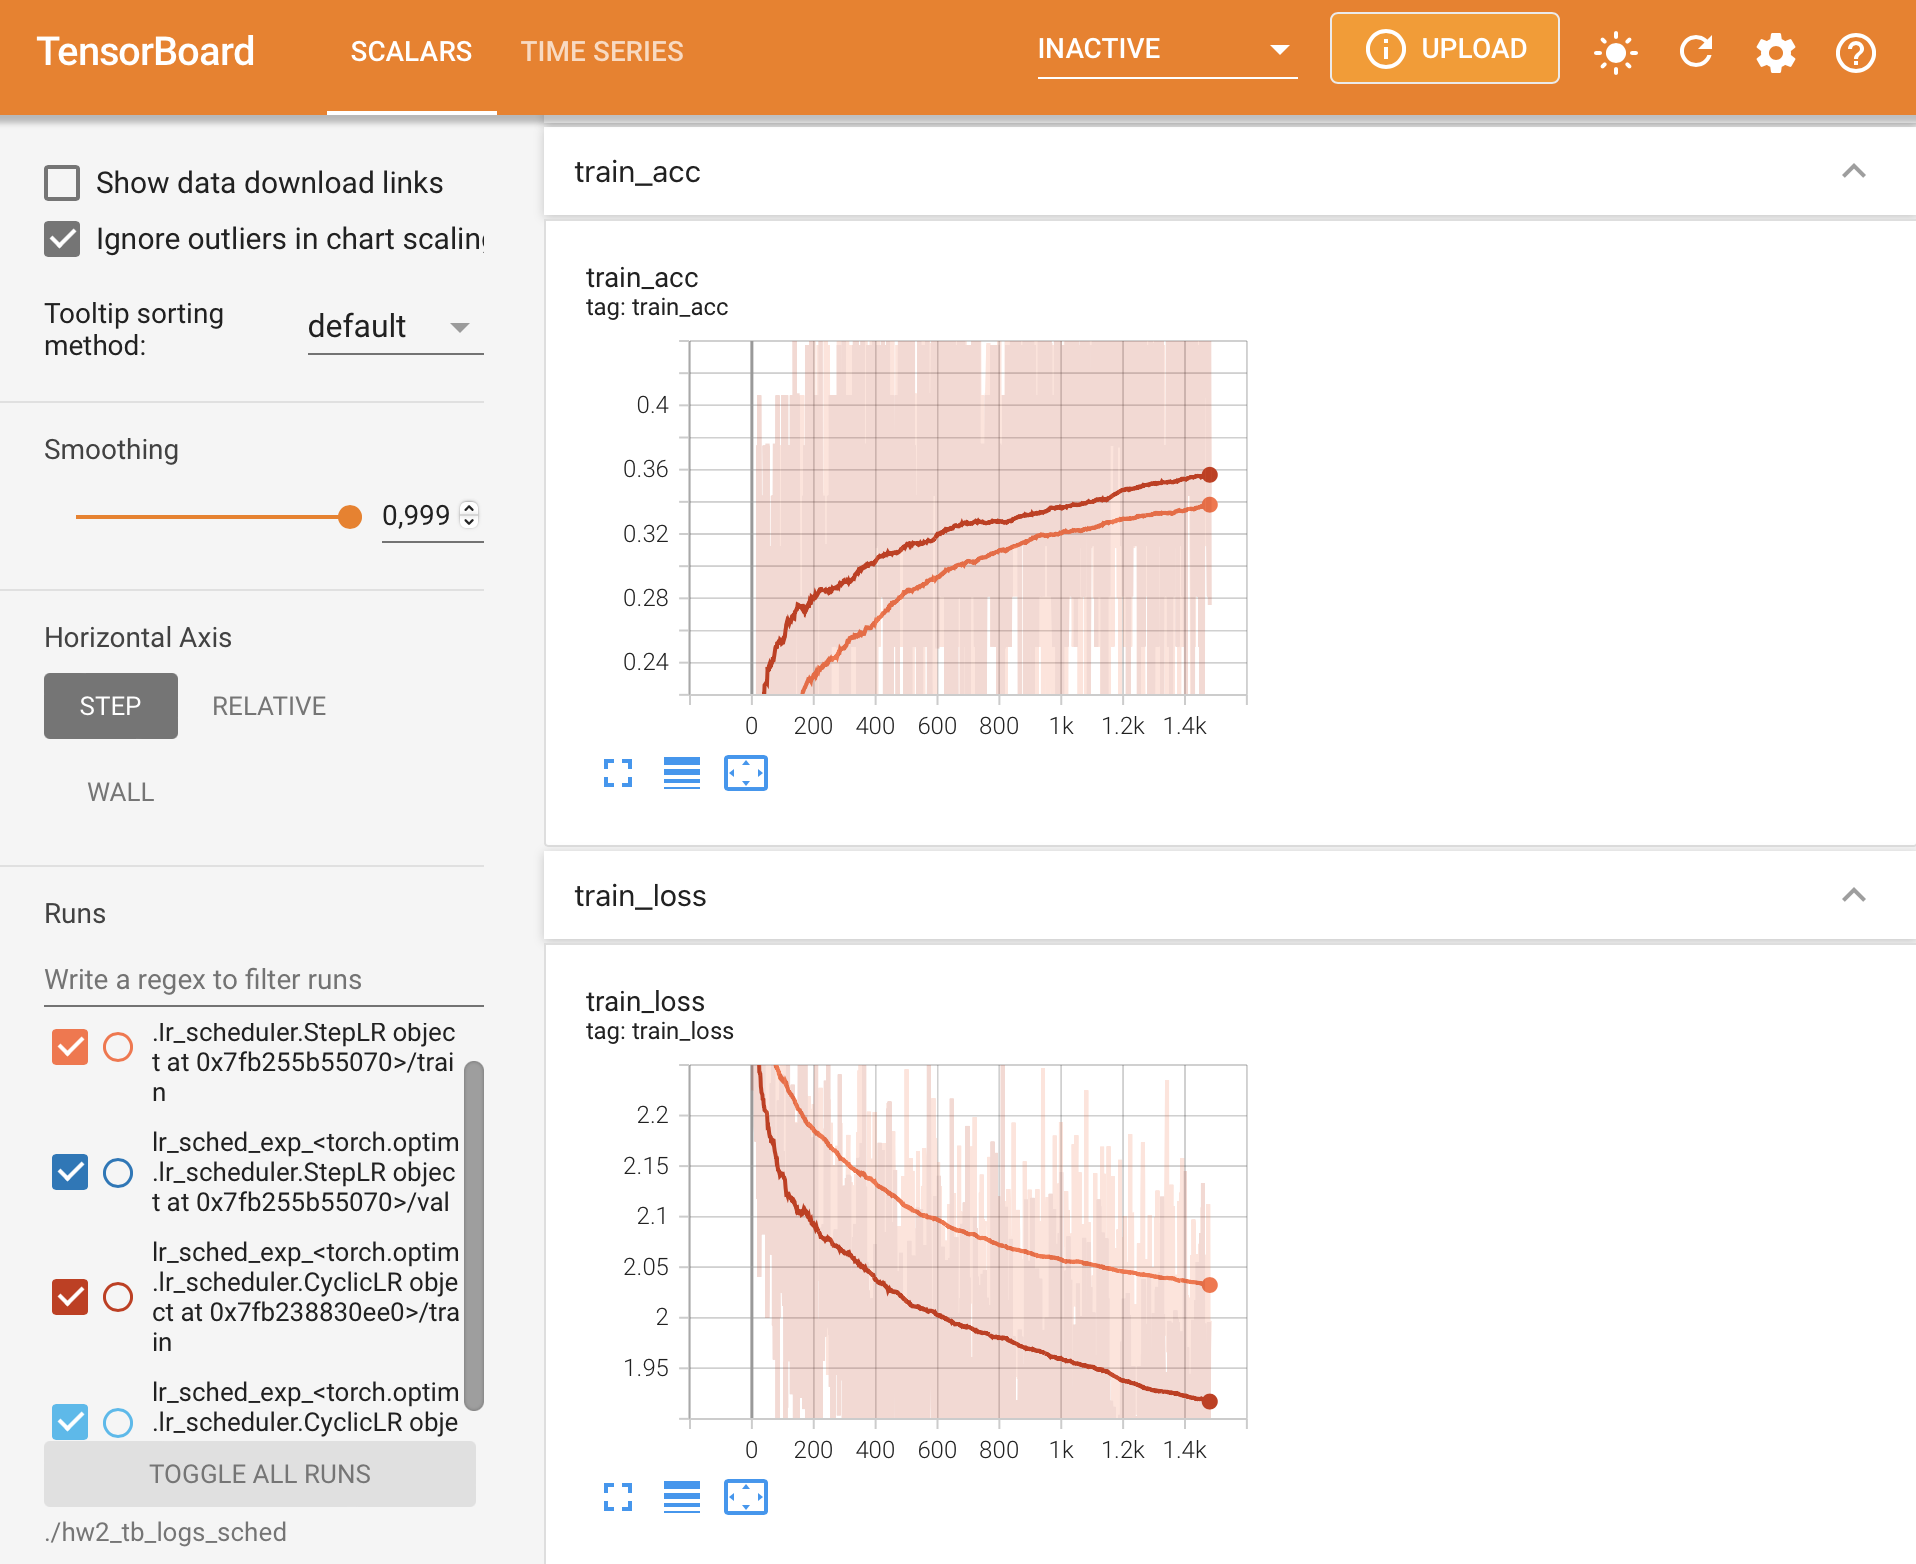

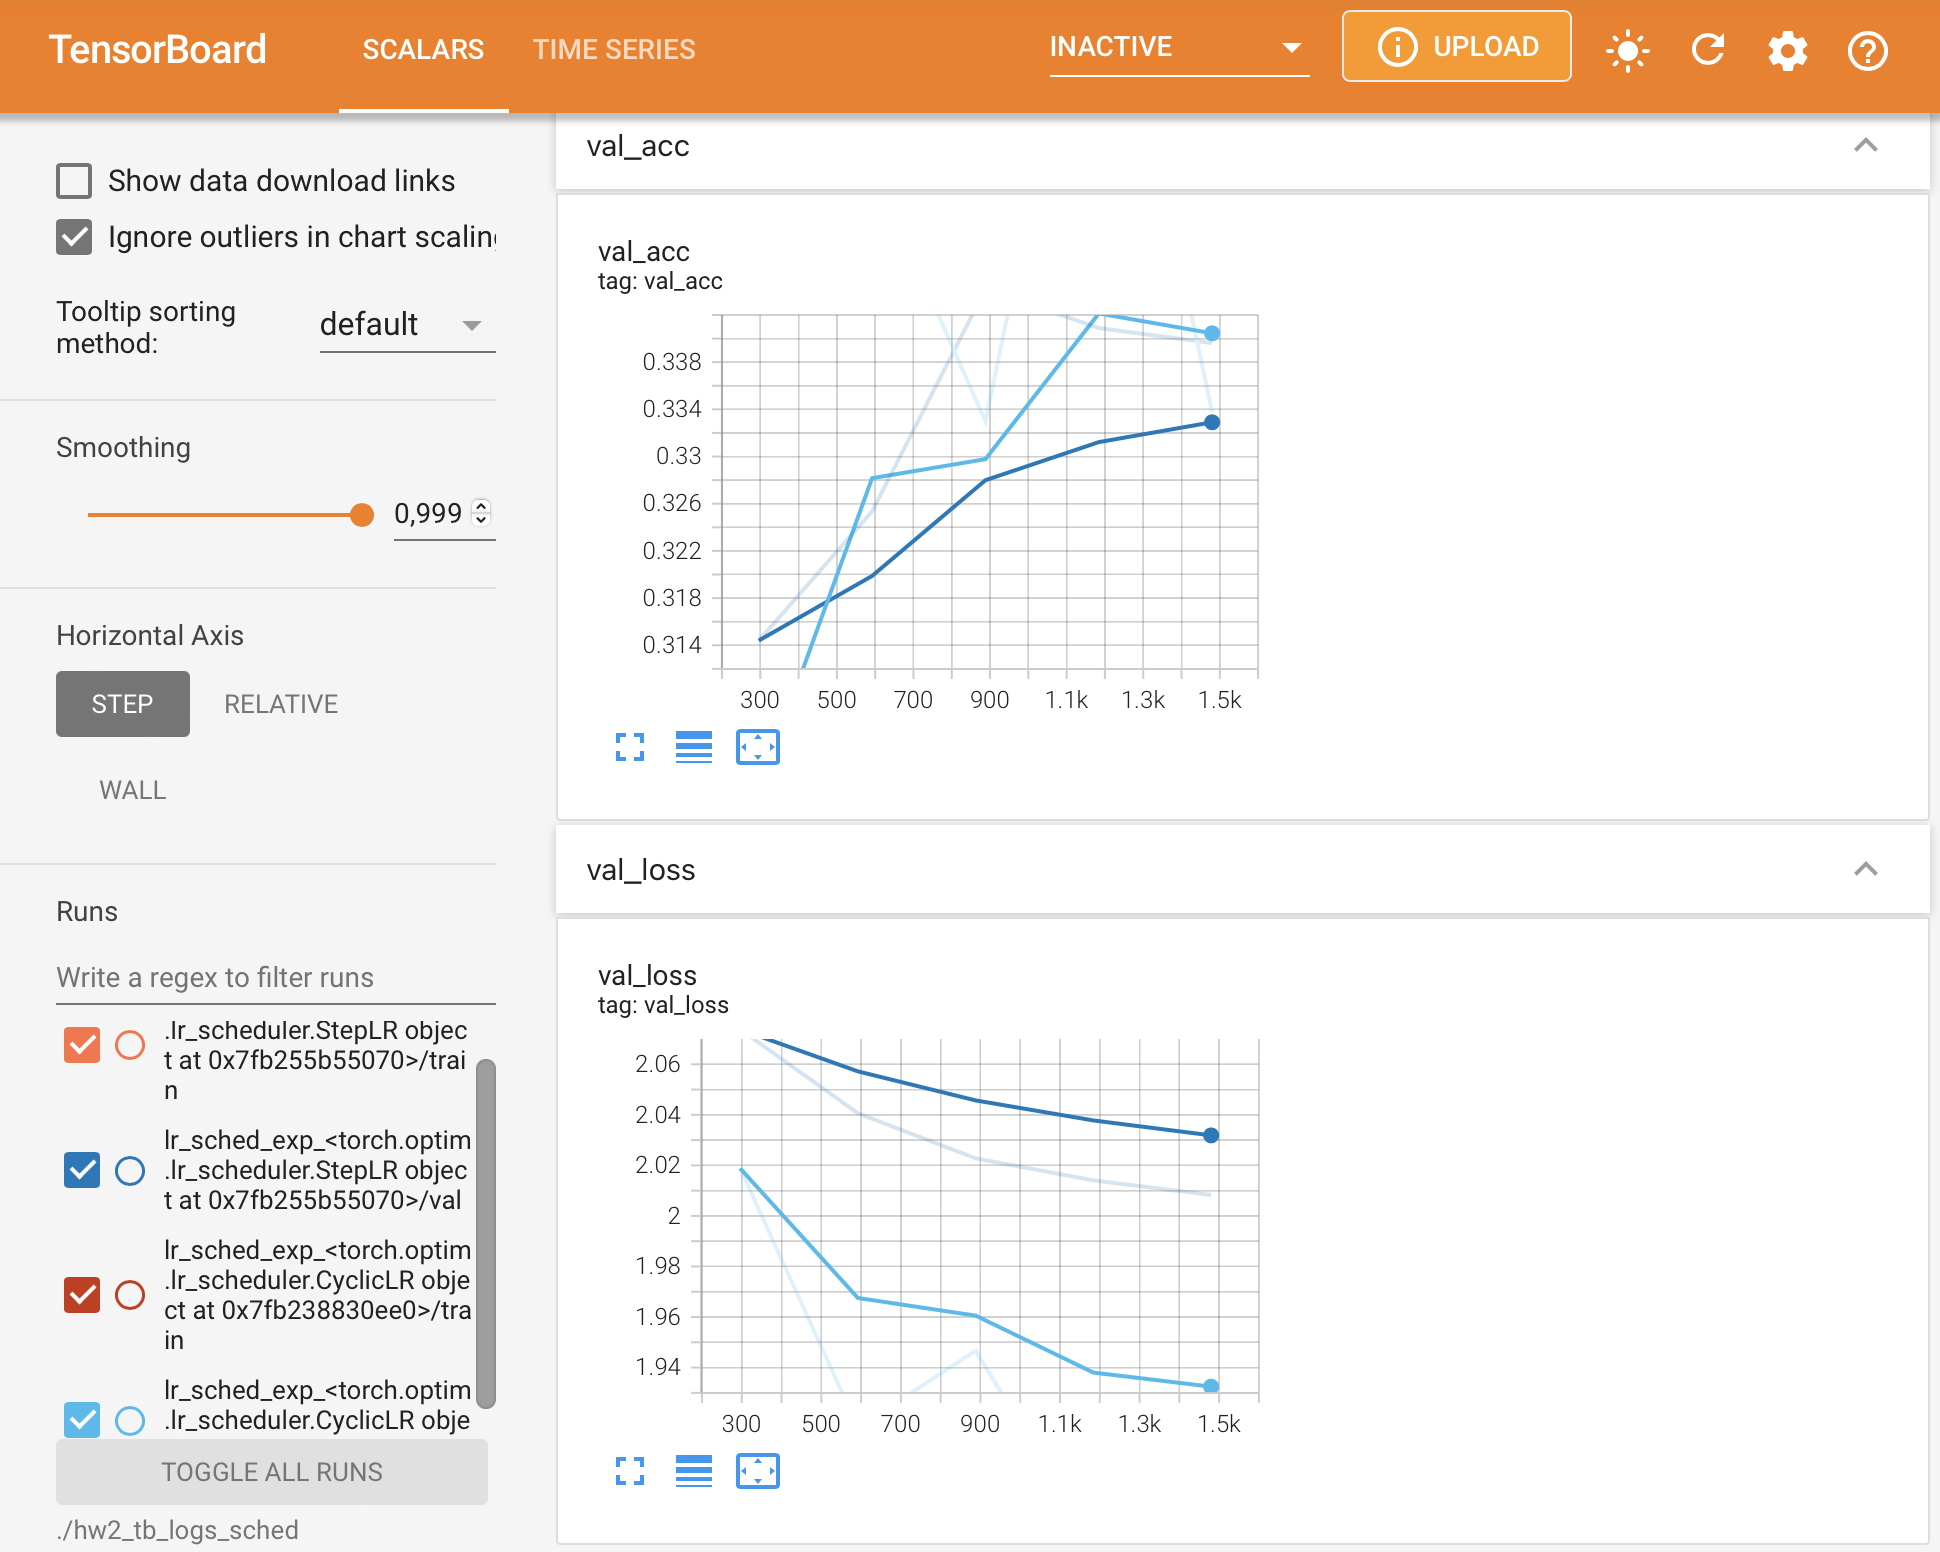

## [0.1 балла] Confusion Matrix Heatmap

Покажите на каких классах лучшая сеть ошибается сильнее всего на валидационном датасете.

Выведите матрицу ошибок в виде heatmap.




In [42]:
best_model = model_cyclic

# best_lr = 3e-3
# tboard_logdir = './hw2_tb_logs_sched/'
# image_size = 128

# bs = 32
# aug = RandomRotation(30)

# best_model = VeryModel(image_size)
# optimizer = SGD(best_model.parameters(), lr=best_lr)

# transform = Compose([
#                     ToTensor(),
#                     Resize((image_size, image_size)),
# ])

# train_imagenet = ImagenetteDataset(train=True, transform=transform, augmentation=aug)
# val_imagenet = ImagenetteDataset(train=False, transform=transform)

# lr_sched = CyclicLR(optimizer, base_lr=best_lr, max_lr=7e-3, verbose=False)
# sched_type = 'per_epoch'

# trainer = Trainer(best_model, optimizer, train_imagenet, val_imagenet, 
#                   batch_size=bs, lr_scheduler=lr_sched, lr_scheduler_type=sched_type,
#                   tboard_log_dir=tboard_logdir, exp_name='lr_scheduler')
# trainer.train(5)

In [49]:
all_val = DataLoader(val_imagenet, shuffle=False, pin_memory=True, 
                     batch_size=len(val_imagenet))


with torch.no_grad():
    for batch in tqdm(all_val):
        batch = {k: v.to(trainer.device) for k, v in batch.items()}
        logits = best_model.forward(batch['image'])
        y_pred = logits.argmax(axis=1).cpu().numpy()
        print(y_pred)
        y_true = batch['label'].numpy()
        print(y_true)


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]

[2 4 2 ... 5 5 5]
[2 2 2 ... 7 7 7]


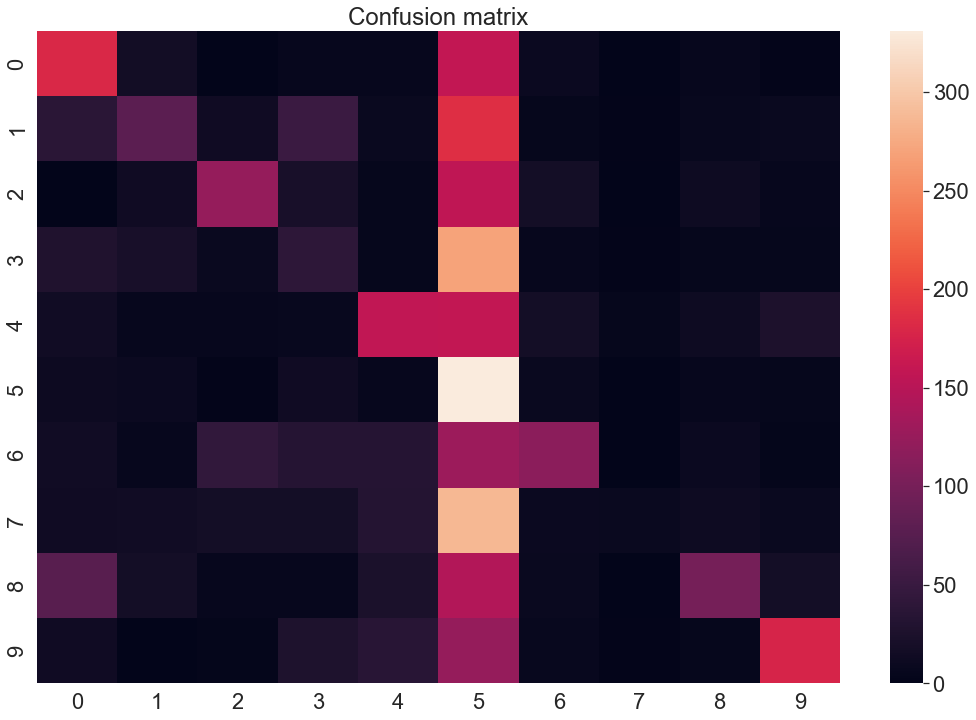

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

error_matrix = confusion_matrix(y_true, y_pred)
sns.set(rc={'figure.figsize':(18, 12)})
plt.rcParams["axes.labelsize"] = 80
sns.set(font_scale=2)
plt.title('Confusion matrix')
sns.heatmap(error_matrix);

In [70]:
error_matrix

array([[181,  16,   1,   6,   6, 159,  10,   0,   6,   2],
       [ 37,  78,  13,  51,   8, 186,   4,   2,   7,   9],
       [  0,  14, 124,  21,   5, 156,  18,   1,  12,   6],
       [ 28,  21,   8,  39,   5, 269,   6,   2,   4,   4],
       [ 15,   6,   6,   7, 157, 159,  17,   5,  12,  25],
       [ 11,  10,   2,  14,   6, 331,   9,   1,   6,   4],
       [ 15,   6,  43,  33,  33, 129, 116,   1,  10,   3],
       [ 13,  15,  17,  17,  32, 287,  10,   8,  12,   8],
       [ 76,  17,   6,   6,  24, 145,   9,   0,  99,  17],
       [ 13,   0,   3,  26,  35, 123,   7,   2,   4, 177]])